# Coding Assignment 2 | Problem 3:
Andrew Sivaprakasam

BME 695 Numerical Methods 

Dependent on a few packages, see import statments.


## Task 3 | LHS Design 

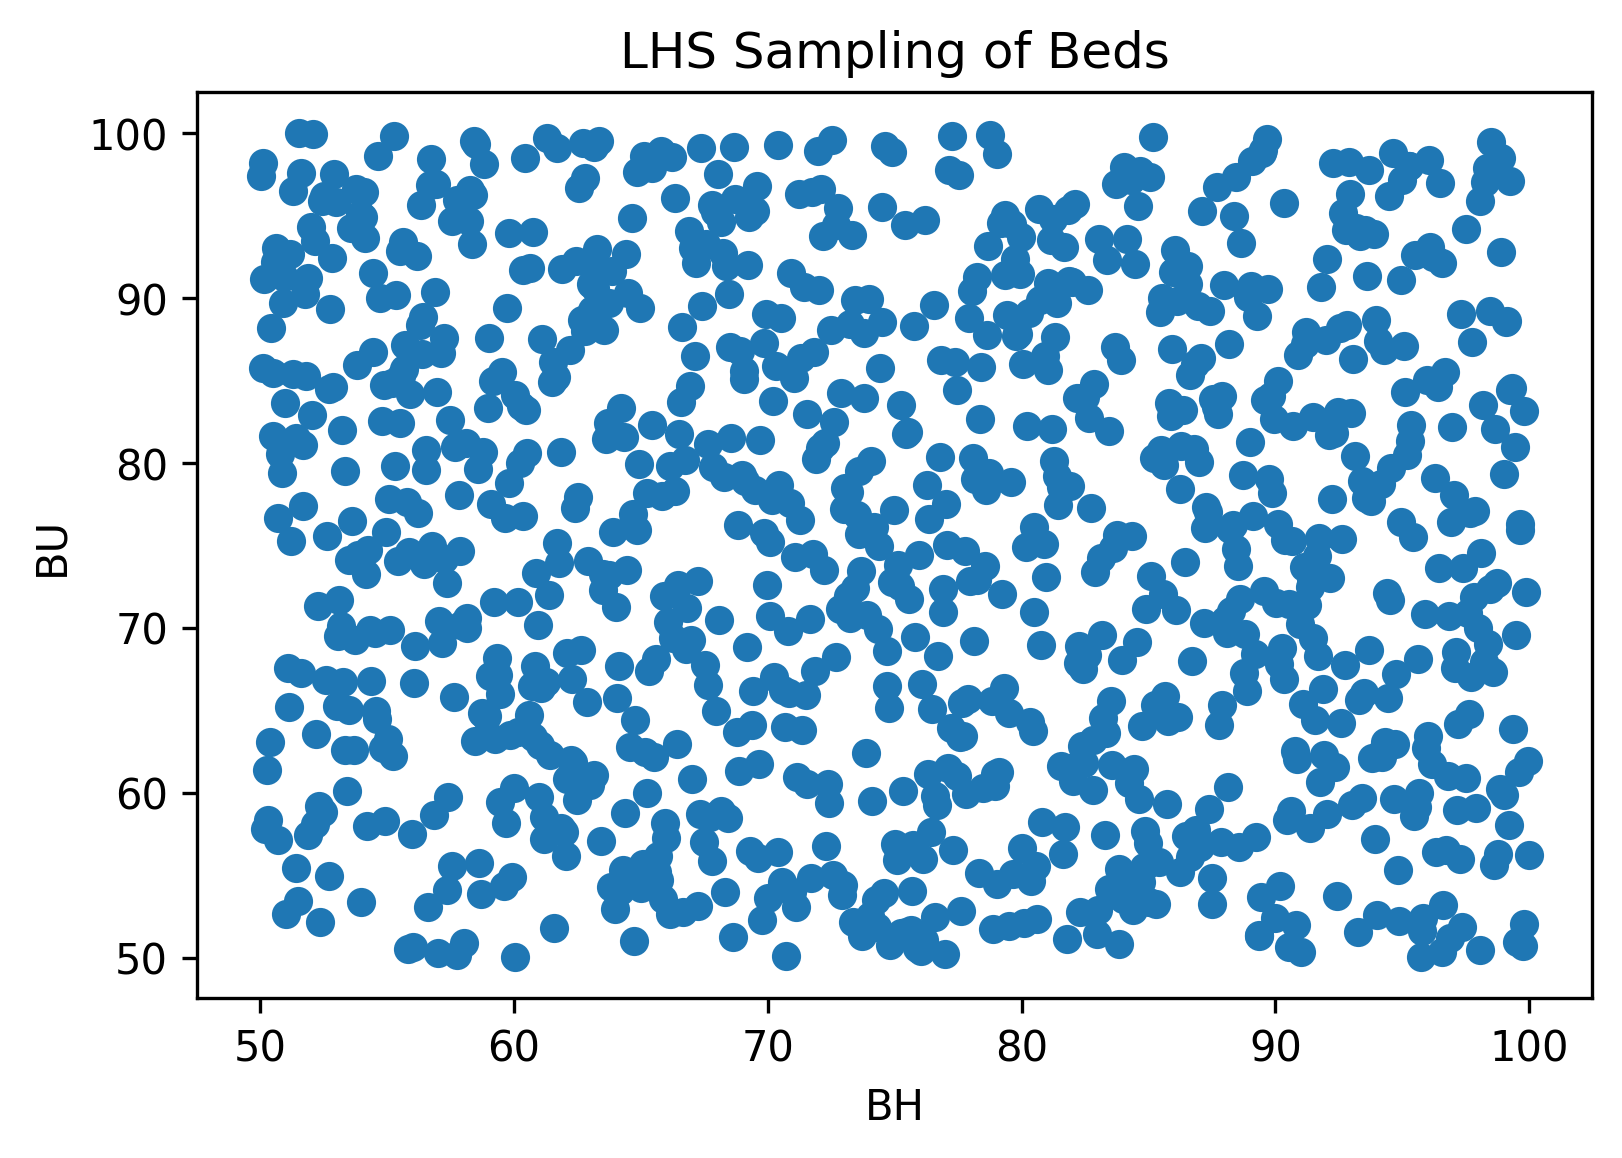

In [3]:
from main import main
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs
import numpy as np
import pickle
from joblib import Parallel, delayed


%matplotlib inline

bed_min = 50;
bed_max = 100;
bed_range = bed_max-bed_min;

#Generate the lhs samples
test = lhs(2, samples = 1000)
test = bed_min + test*(bed_range);
test = np.asarray(test);

#verify samples
BH,BU = test.T;
plt.figure(dpi=300)
plot1 = plt.scatter(BH,BU);
plt.title('LHS Sampling of Beds');
plt.xlabel('BH');
plt.ylabel('BU');
plt.savefig('LHS_GT.png', bbox_inches='tight')

## For Easy Parallelization:
This also runs the ground truth simulation used for training models.

In [12]:
def main_p(bh,bu):
    r = main(bh,bu,5)
     
    print(r);
    return r

In [2]:
#simulate 
r = np.zeros(len(BH));
r = Parallel(n_jobs = -1, verbose = 0)(delayed(main_p)(BH[i],BU[i]) for i in range(0,len(BH)))

## Pickle to save time:
Just saves everthing nicely in a file. 

In [4]:
#save data to file:
#pickle.dump([BH,BU,r], open("1000_sims", "wb"))
BH,BU,r = pickle.load(open("1000_sims","rb"))

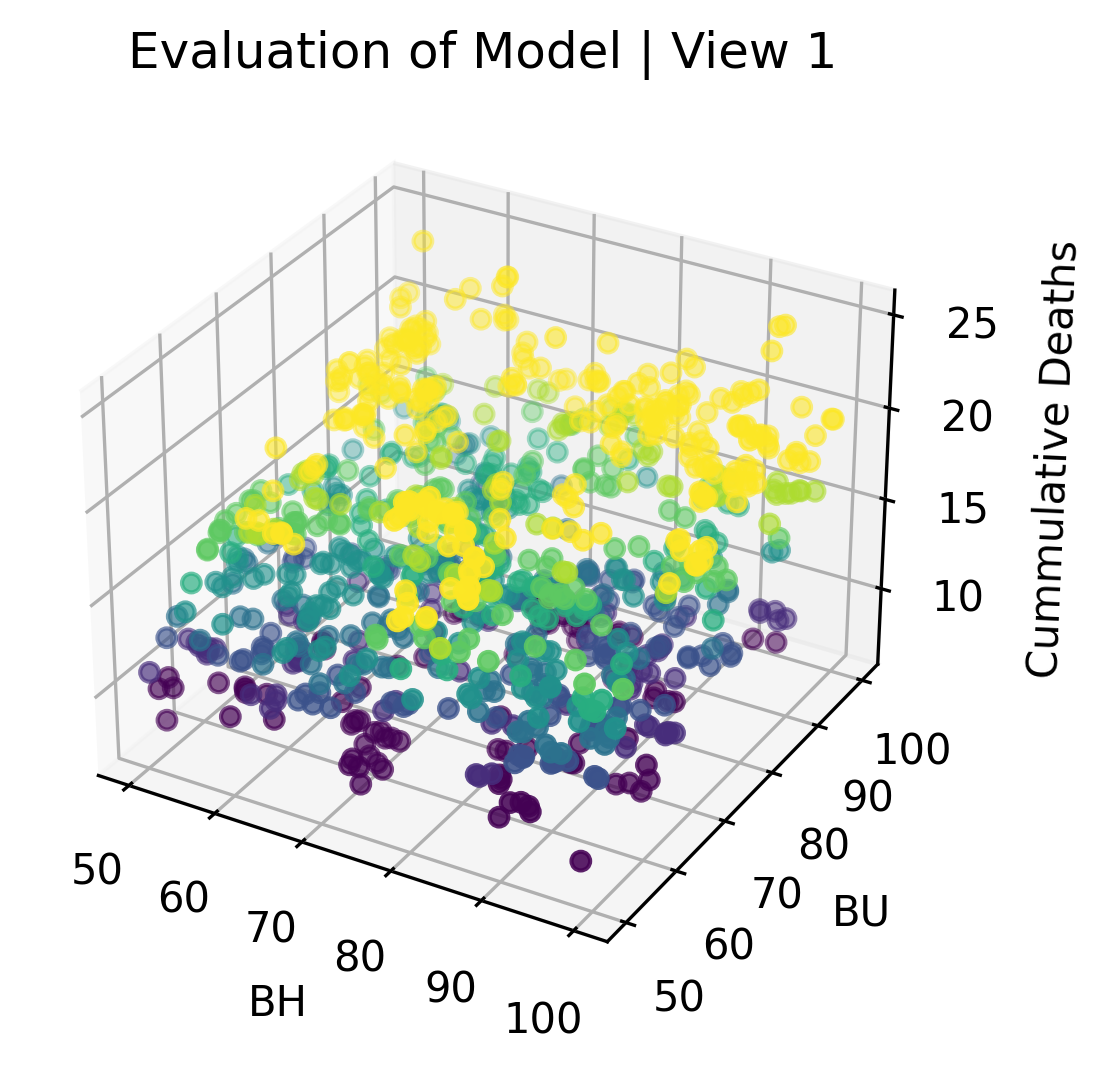

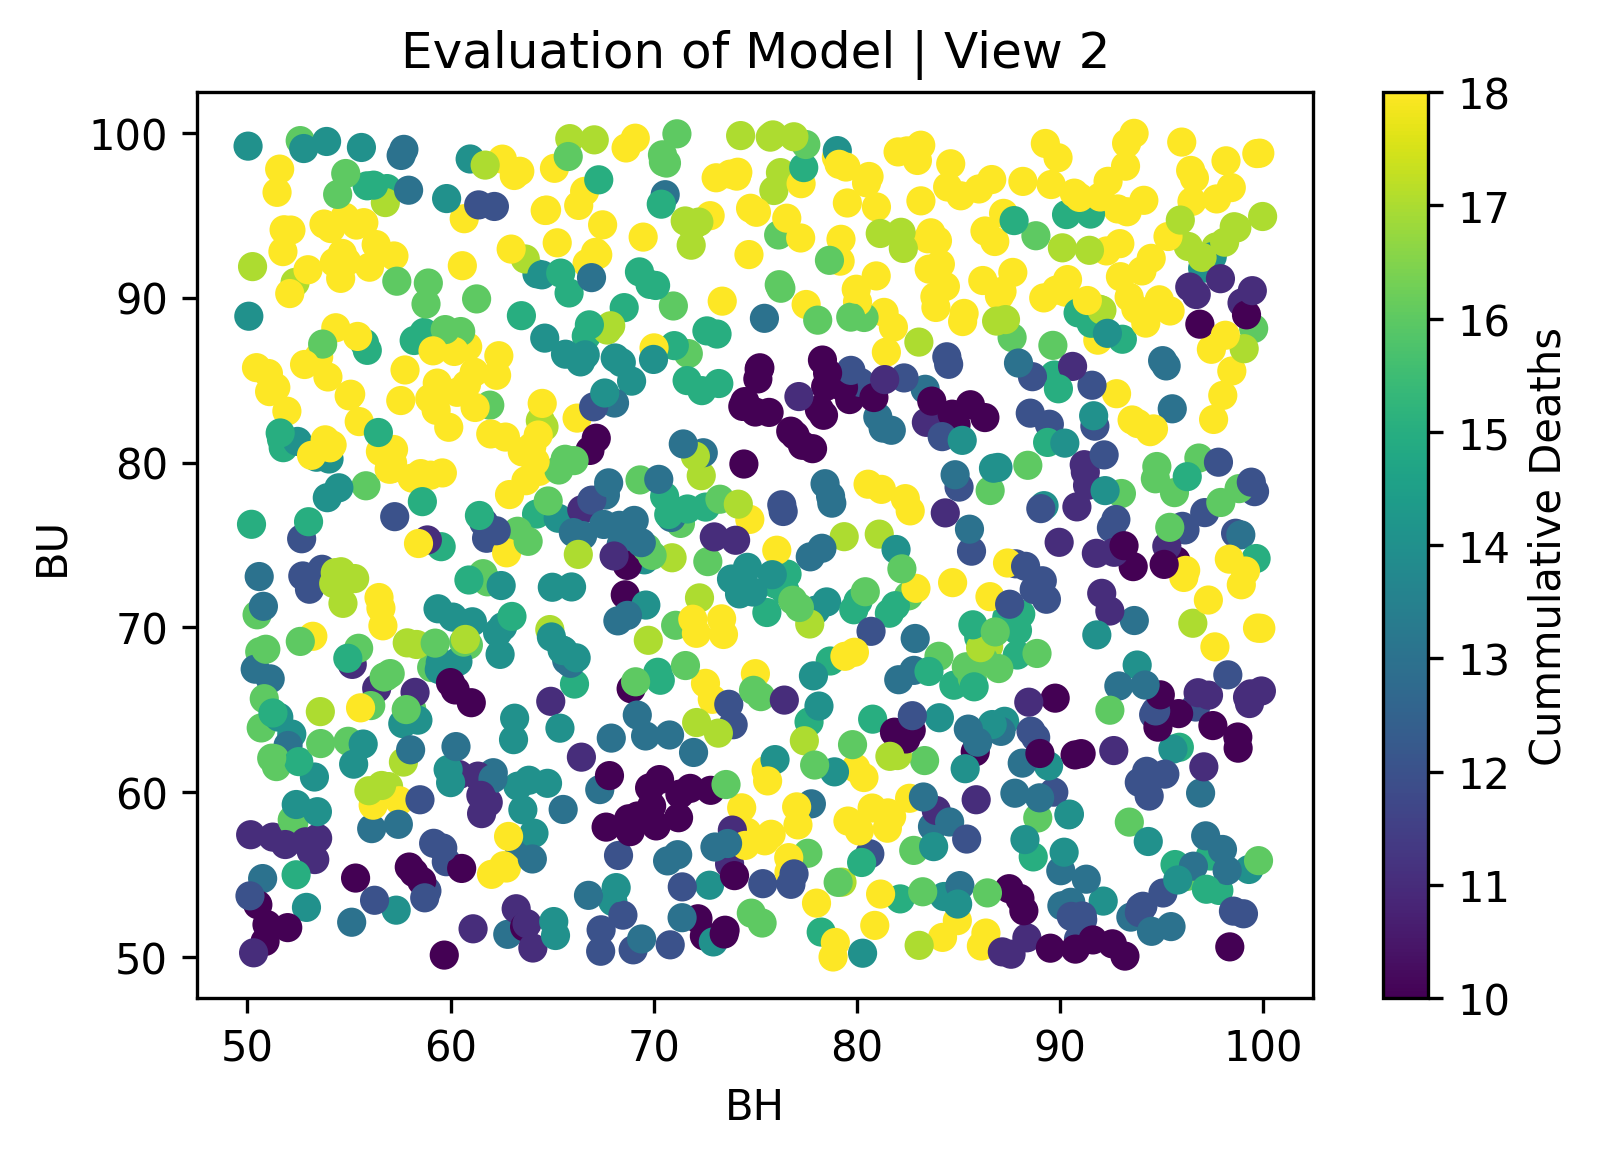

In [5]:
#plot data:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=300)
surf = ax.scatter(BH, BU, r,c = r,vmin=10, vmax=18)
plt.title('Evaluation of Model | View 1')
plt.ylabel('BU');
plt.xlabel('BH');
ax.set_zlabel('Cummulative Deaths');
plt.savefig('GT_Sim1.png', bbox_inches='tight')

plt.figure(dpi=300)
plot1 = plt.scatter(BH,BU,c = r,vmin=10, vmax=18)
plt.colorbar(label = 'Cummulative Deaths')
plt.ylabel('BU')
plt.xlabel('BH')
plt.title('Evaluation of Model | View 2')
plt.savefig('GT_Sim2.png', bbox_inches='tight')

In [6]:
#generate LHS samples at lower res for metamodeling

test = lhs(2, samples = 50)
test = bed_min + test*(bed_range);
test = np.asarray(test);

BH_i, BU_i = test.T;

## Task 3a | IDW Implementation:
Based on the implementation found here https://rafatieppo.github.io/post/2018_07_27_idw2pyr/:

Modified to handle a pythagorean distance.

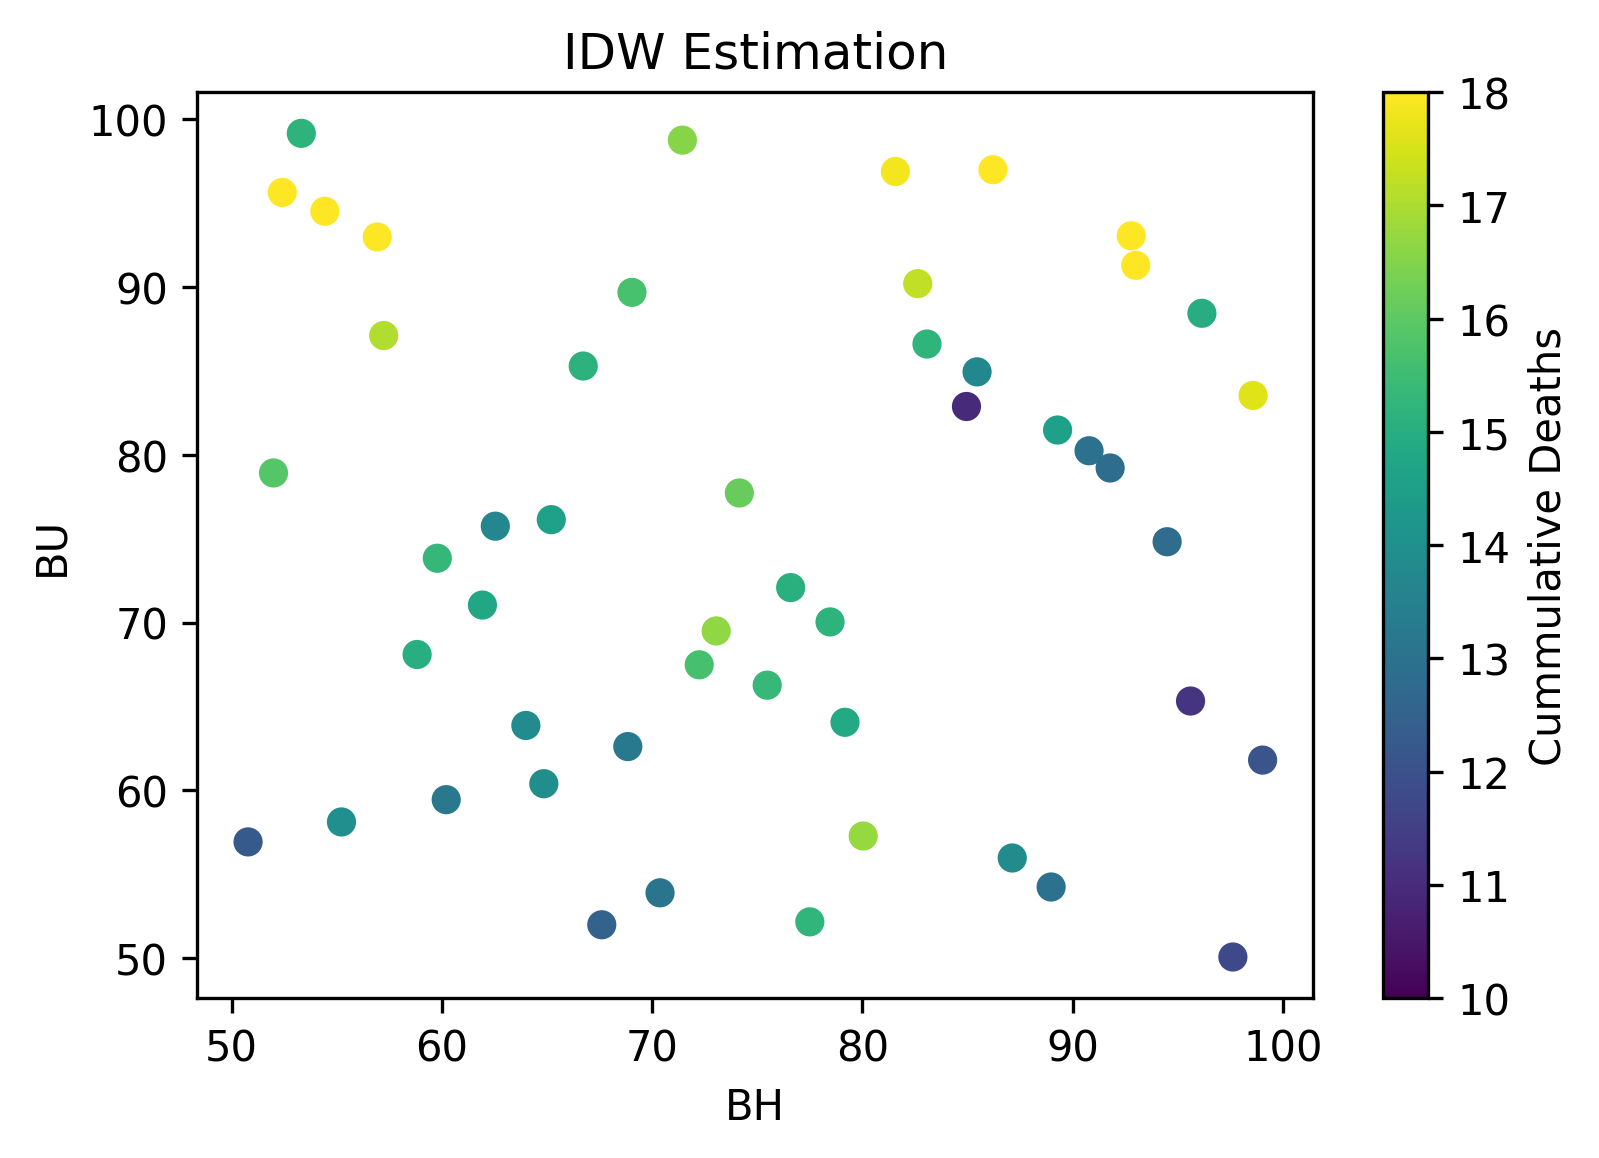

In [7]:
#Implement IDW 

def distance(x, y, xi, yi):
    d = np.sqrt((x-xi)**2 + (y-yi)**2);
    return(d)

def idwr(x, y, z, xi, yi):
    lstxyzi = []
    for p in range(len(xi)):
        lstdist = []
        for s in range(len(x)):
            d = distance(x[s], y[s], xi[p], yi[p])
            lstdist.append(d)
        sumsup = list((1 / np.power(lstdist, 2)))
        suminf = np.sum(sumsup)
        sumsup = np.sum(np.array(sumsup) * z)
        u = sumsup / suminf
        xyzi = u
        lstxyzi.append(xyzi)
    return(lstxyzi)

r_i_IDW = idwr(BH,BU,r,BH_i,BU_i);
plt.figure(dpi=300)
plot1 = plt.scatter(BH_i,BU_i,c = r_i_IDW,vmin=10, vmax=18)
plt.ylabel('BU')
plt.xlabel('BH')
plt.title('IDW Estimation')
plt.colorbar(label = 'Cummulative Deaths');
plt.savefig('IDW.png', bbox_inches='tight')

## Task 3b | RBF Implementation:

Uses scipy:

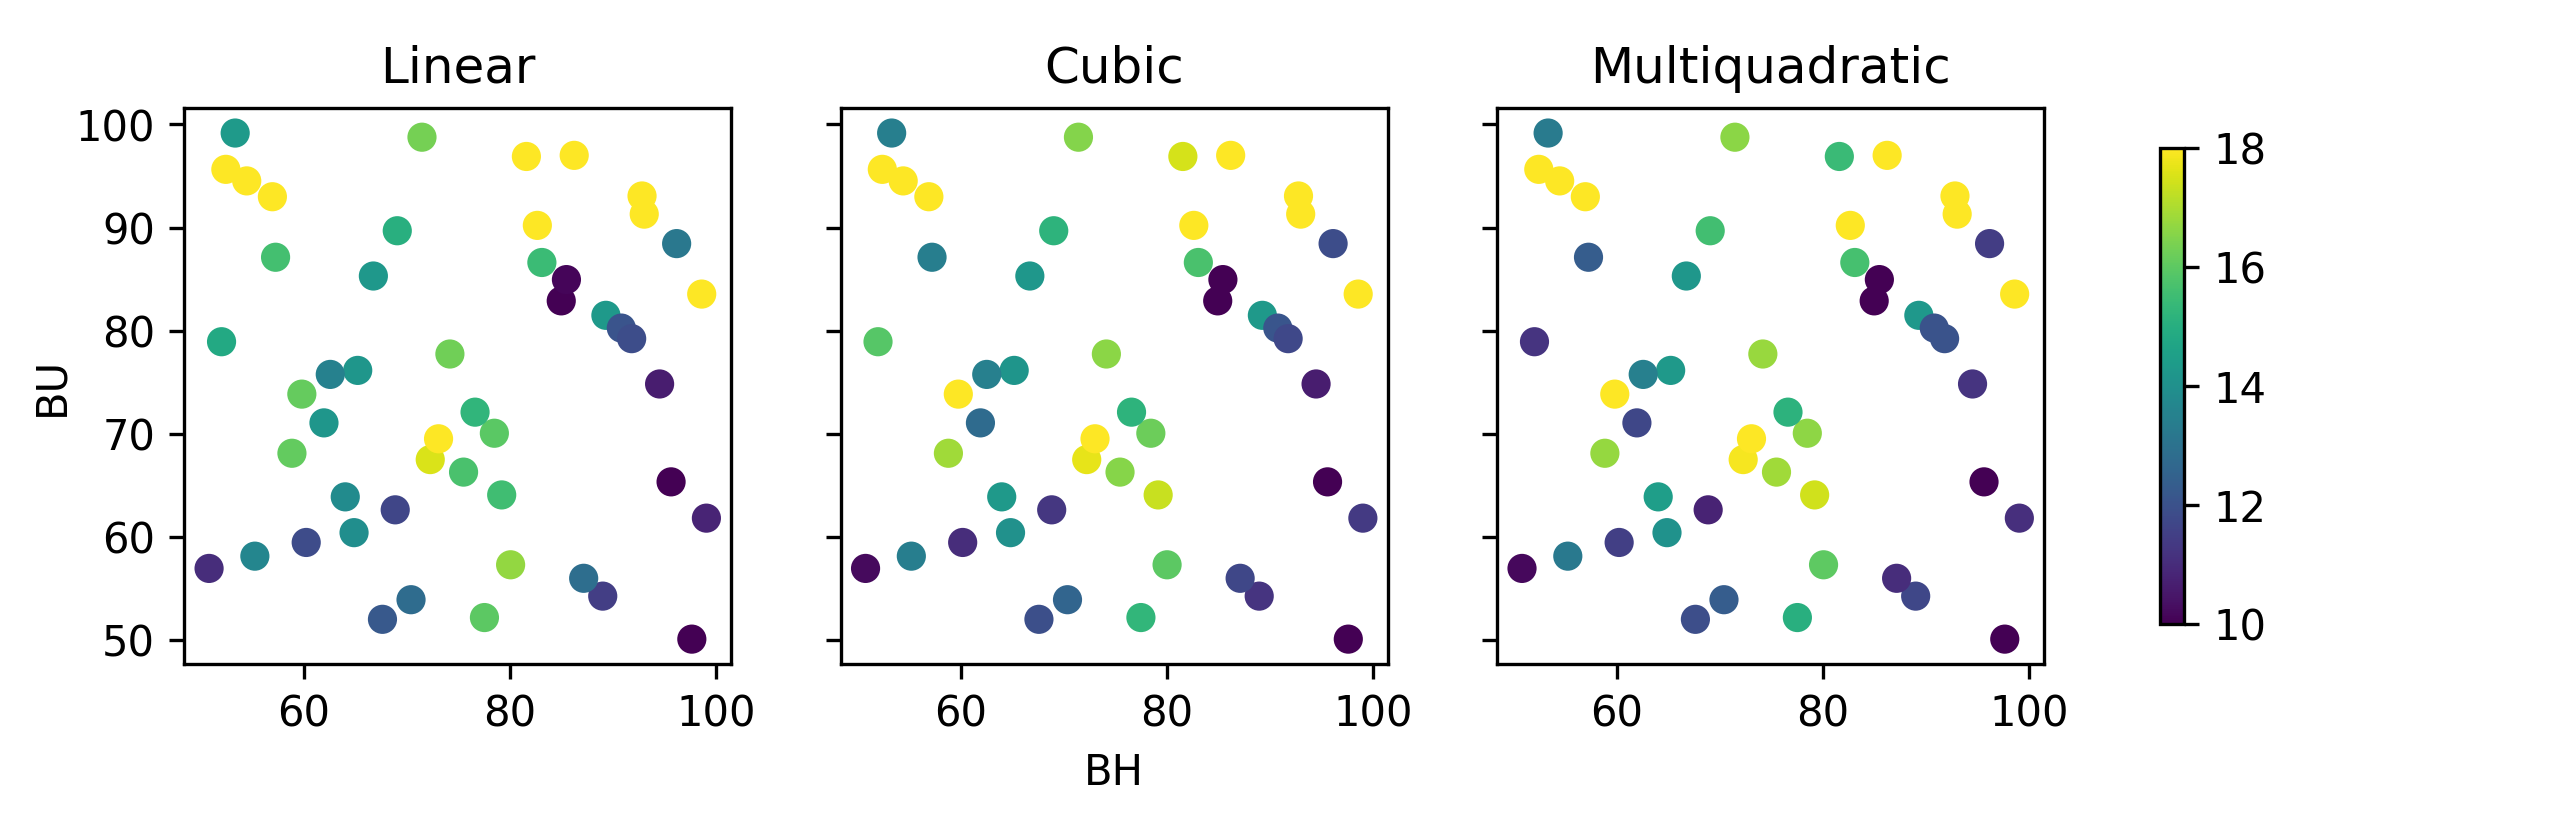

In [8]:
#Implement RBF
from scipy.interpolate import Rbf

def cubilinear(self, r):
    return r**3 + r

rbf_i_lin = Rbf(BH, BU, r,function = 'linear');
rbf_i_cub = Rbf(BH, BU, r,function = 'cubic');
rbf_i_mq = Rbf(BH, BU, r)
r_i_RBF_lin = rbf_i_lin(BH_i, BU_i);
r_i_RBF_cub = rbf_i_cub(BH_i, BU_i);
r_i_RBF_mq = rbf_i_mq(BH_i, BU_i);



fig, axs = plt.subplots(1,3, sharex = True, sharey = True,figsize=(10, 3), dpi=300)

axs[0].scatter(BH_i,BU_i,c = r_i_RBF_lin,vmin=10, vmax=18)
axs[0].set_title('Linear')
axs[0].set(adjustable='box', aspect='equal')

axs[1].scatter(BH_i,BU_i,c = r_i_RBF_cub,vmin=10, vmax=18)
axs[1].set_title('Cubic')
axs[1].set(adjustable='box', aspect='equal')
axs[1].set_xlabel('BH')



figend = axs[2].scatter(BH_i,BU_i,c = r_i_RBF_mq,vmin=10, vmax=18)
axs[2].set_title('Multiquadratic')
axs[2].set(adjustable = 'box', aspect='equal')

fig.colorbar(figend, ax=axs.ravel().tolist(), shrink = 0.7)

#plt.colorbar(im, label = 'Cummulative Deaths');
fig.add_subplot(111, frameon= False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('BU')
plt.savefig('RBF.png', bbox_inches='tight')

## Task 3c | ANN Implementation:

Uses SciKitLearn tools.

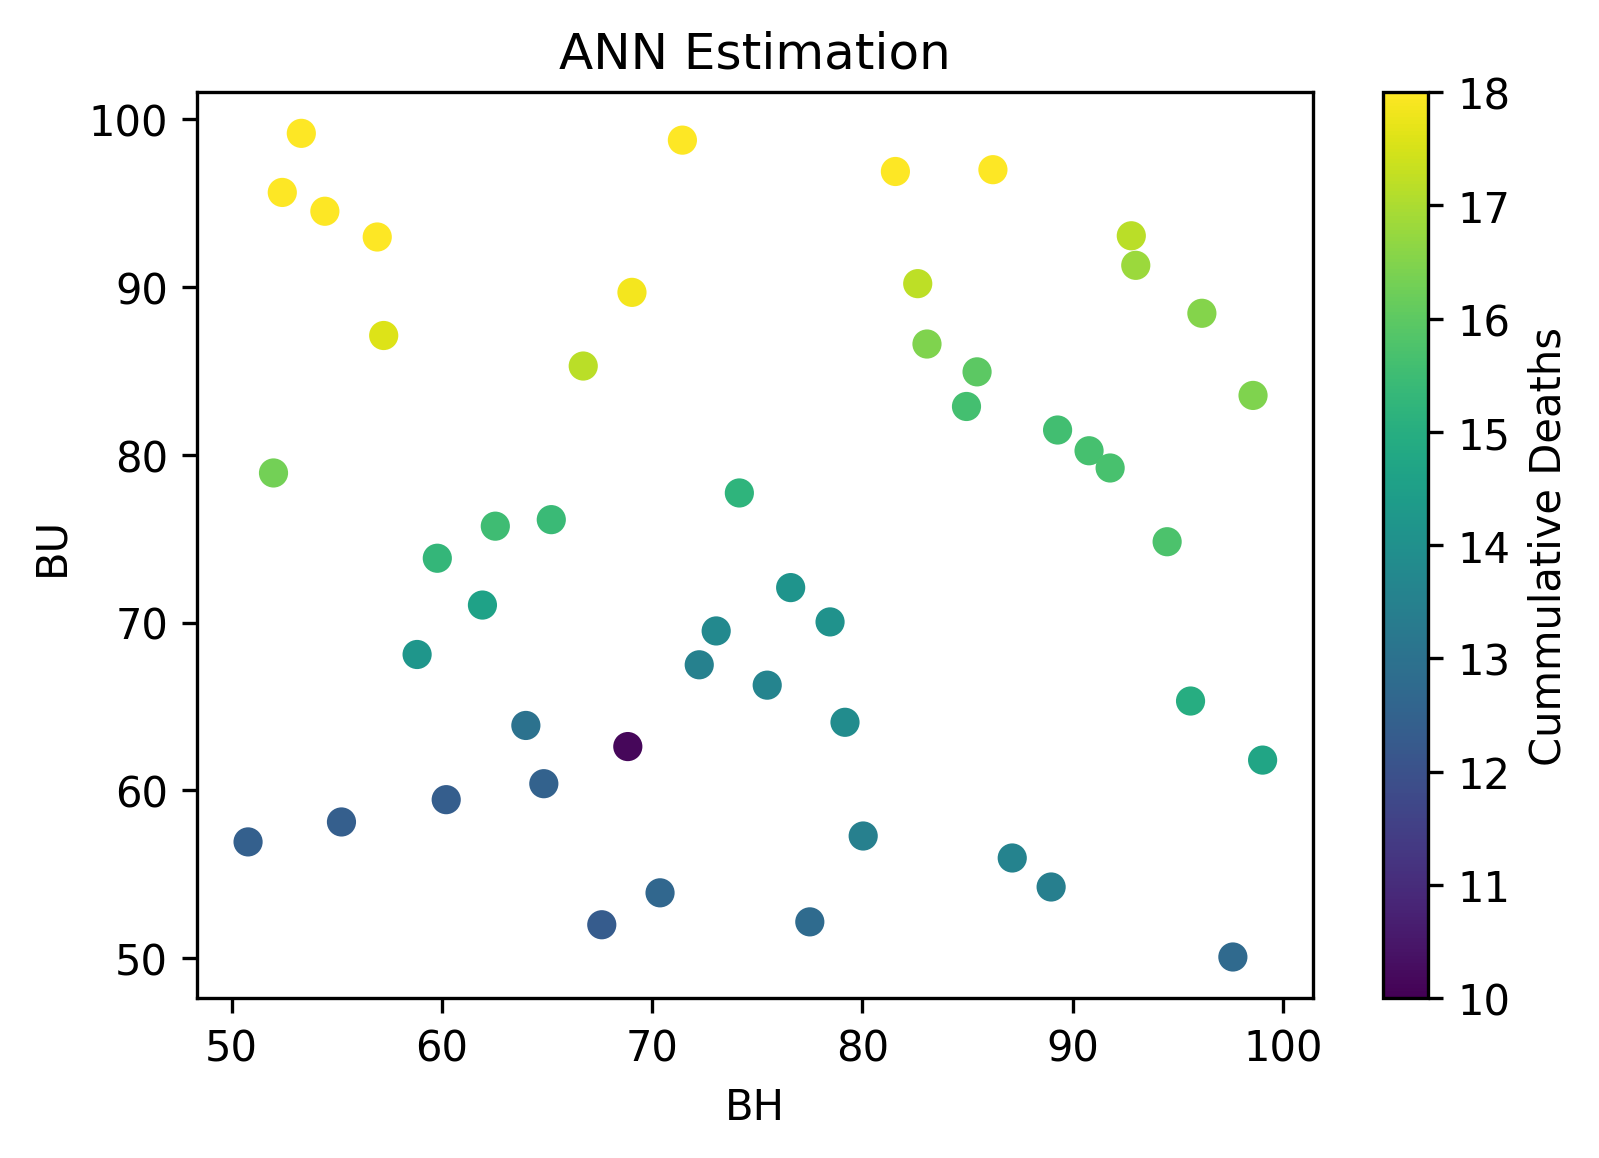

In [9]:
#Implement ANN

from sklearn.neural_network import MLPRegressor

#set up dataframe:
r = np.squeeze(r);
#r = np.reshape(r[:],(500,-1))
data_x = np.zeros((len(BH),2));
data_x_i = np.zeros((len(BH_i),2));

data_y = r;

for i in range(0,len(BH)-1):
    data_x[i] = [BH[i],BU[i]];
    
for i in range(0, len(BH_i)-1) :   
    data_x_i[i] = [BH_i[i],BU_i[i]];

regr = MLPRegressor(random_state=1,max_iter = 2000).fit(data_x,data_y);
regrs = regr.score(data_x,data_y);
r_i_ANN = regr.predict(data_x_i);

plt.figure(dpi=300)
plot2 = plt.scatter(BH_i,BU_i,c = r_i_ANN,vmin=10, vmax=18)
plt.colorbar(label = 'Cummulative Deaths');
plt.ylabel('BU')
plt.xlabel('BH')
plt.title('ANN Estimation');
plt.savefig('ANN.png', bbox_inches='tight')

## Task 3d | SVR Implementation:

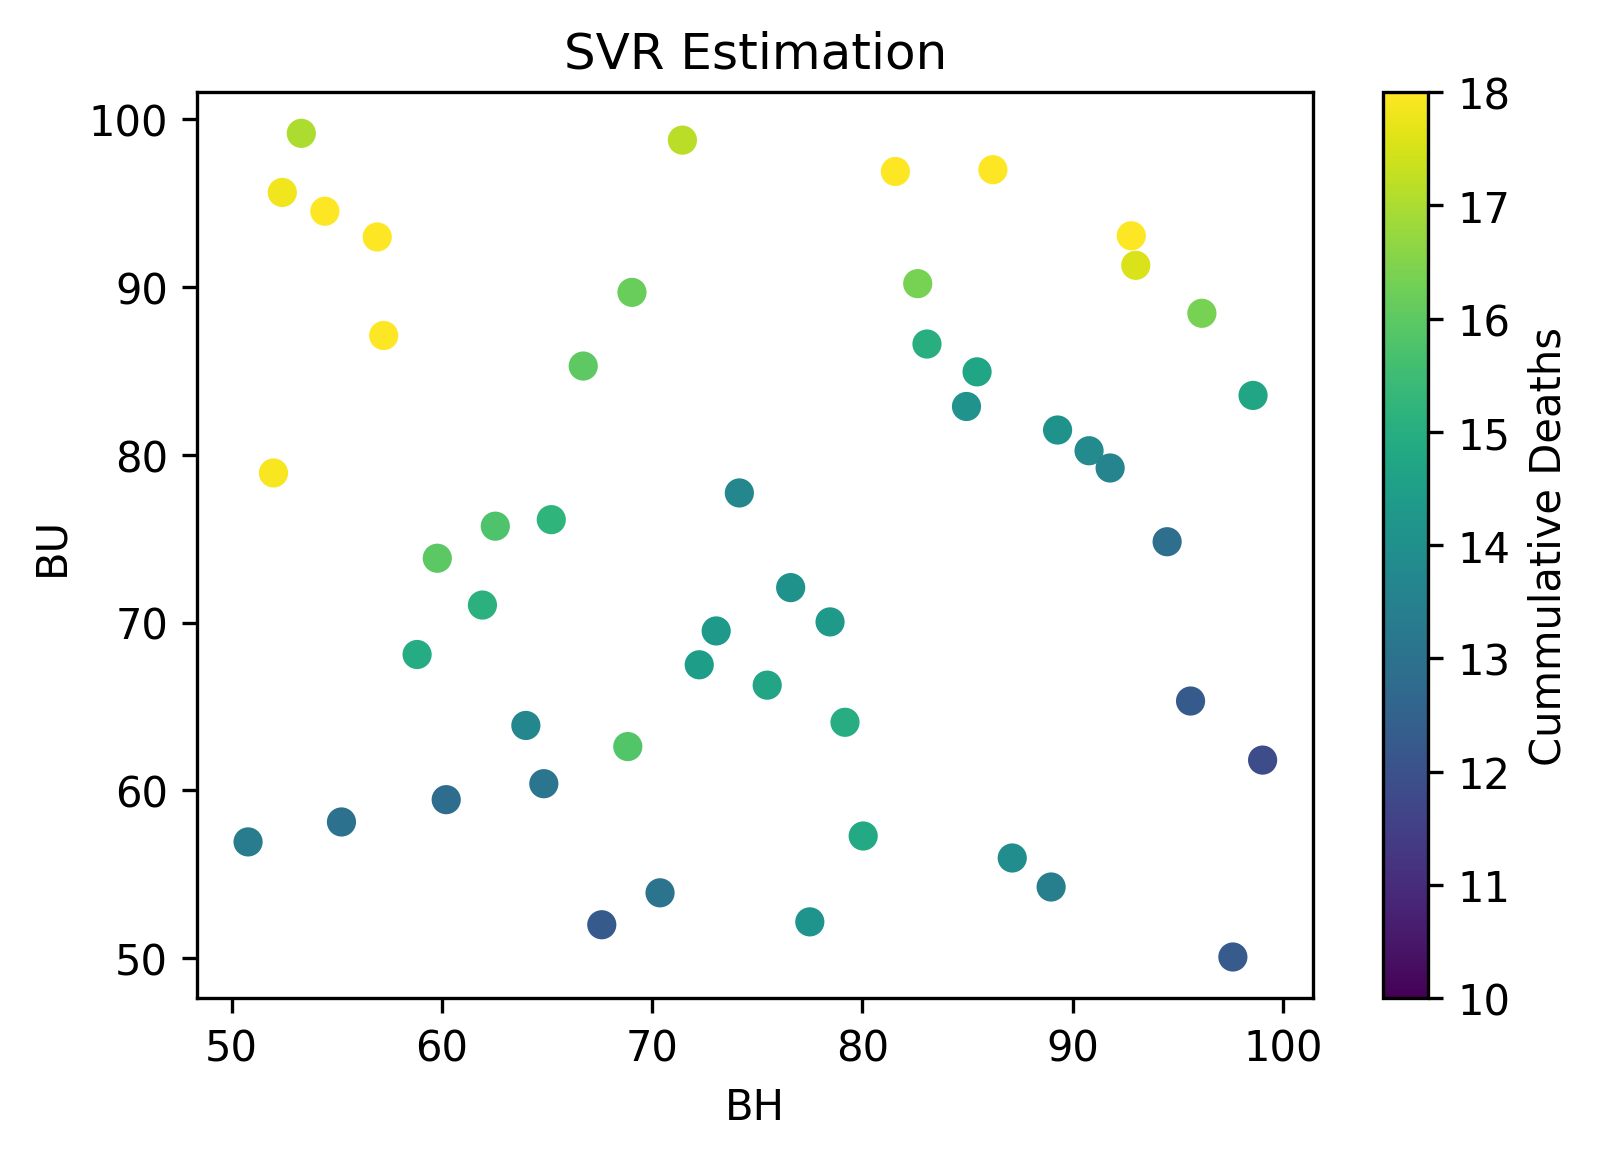

In [10]:
#Implement SVR

from sklearn.svm import SVR

regr = SVR().fit(data_x,data_y);
r_i_SVR = regr.predict(data_x_i);


plt.figure(dpi=300)
plot2 = plt.scatter(BH_i,BU_i,c = r_i_SVR,vmin=10, vmax=18)
plt.colorbar(label = 'Cummulative Deaths');
plt.ylabel('BU')
plt.xlabel('BH')
plt.title('SVR Estimation');
plt.savefig('SVR.png', bbox_inches='tight')

## Comparison to Ground Truths:

In [13]:
#Comparing all 4 Estimations:

#run 50x50 LHS samples with actual model to get a ground truth:
r_i_GT = np.zeros(len(BH_i));
r_i_GT = Parallel(n_jobs = -1, verbose = 0)(delayed(main_p)(BH_i[i],BU_i[i]) for i in range(0,len(BH_i)))

MSE_IDW =  5.238969012918502
MSE_RBF_lin =  4.232139779082131
MSE_RBF_cub =  5.494961352184731
MSE_RBF_mq =  6.722711835960569
MSE_ANN =  10.593338128827456
MSE_SVR =  8.328352323570387


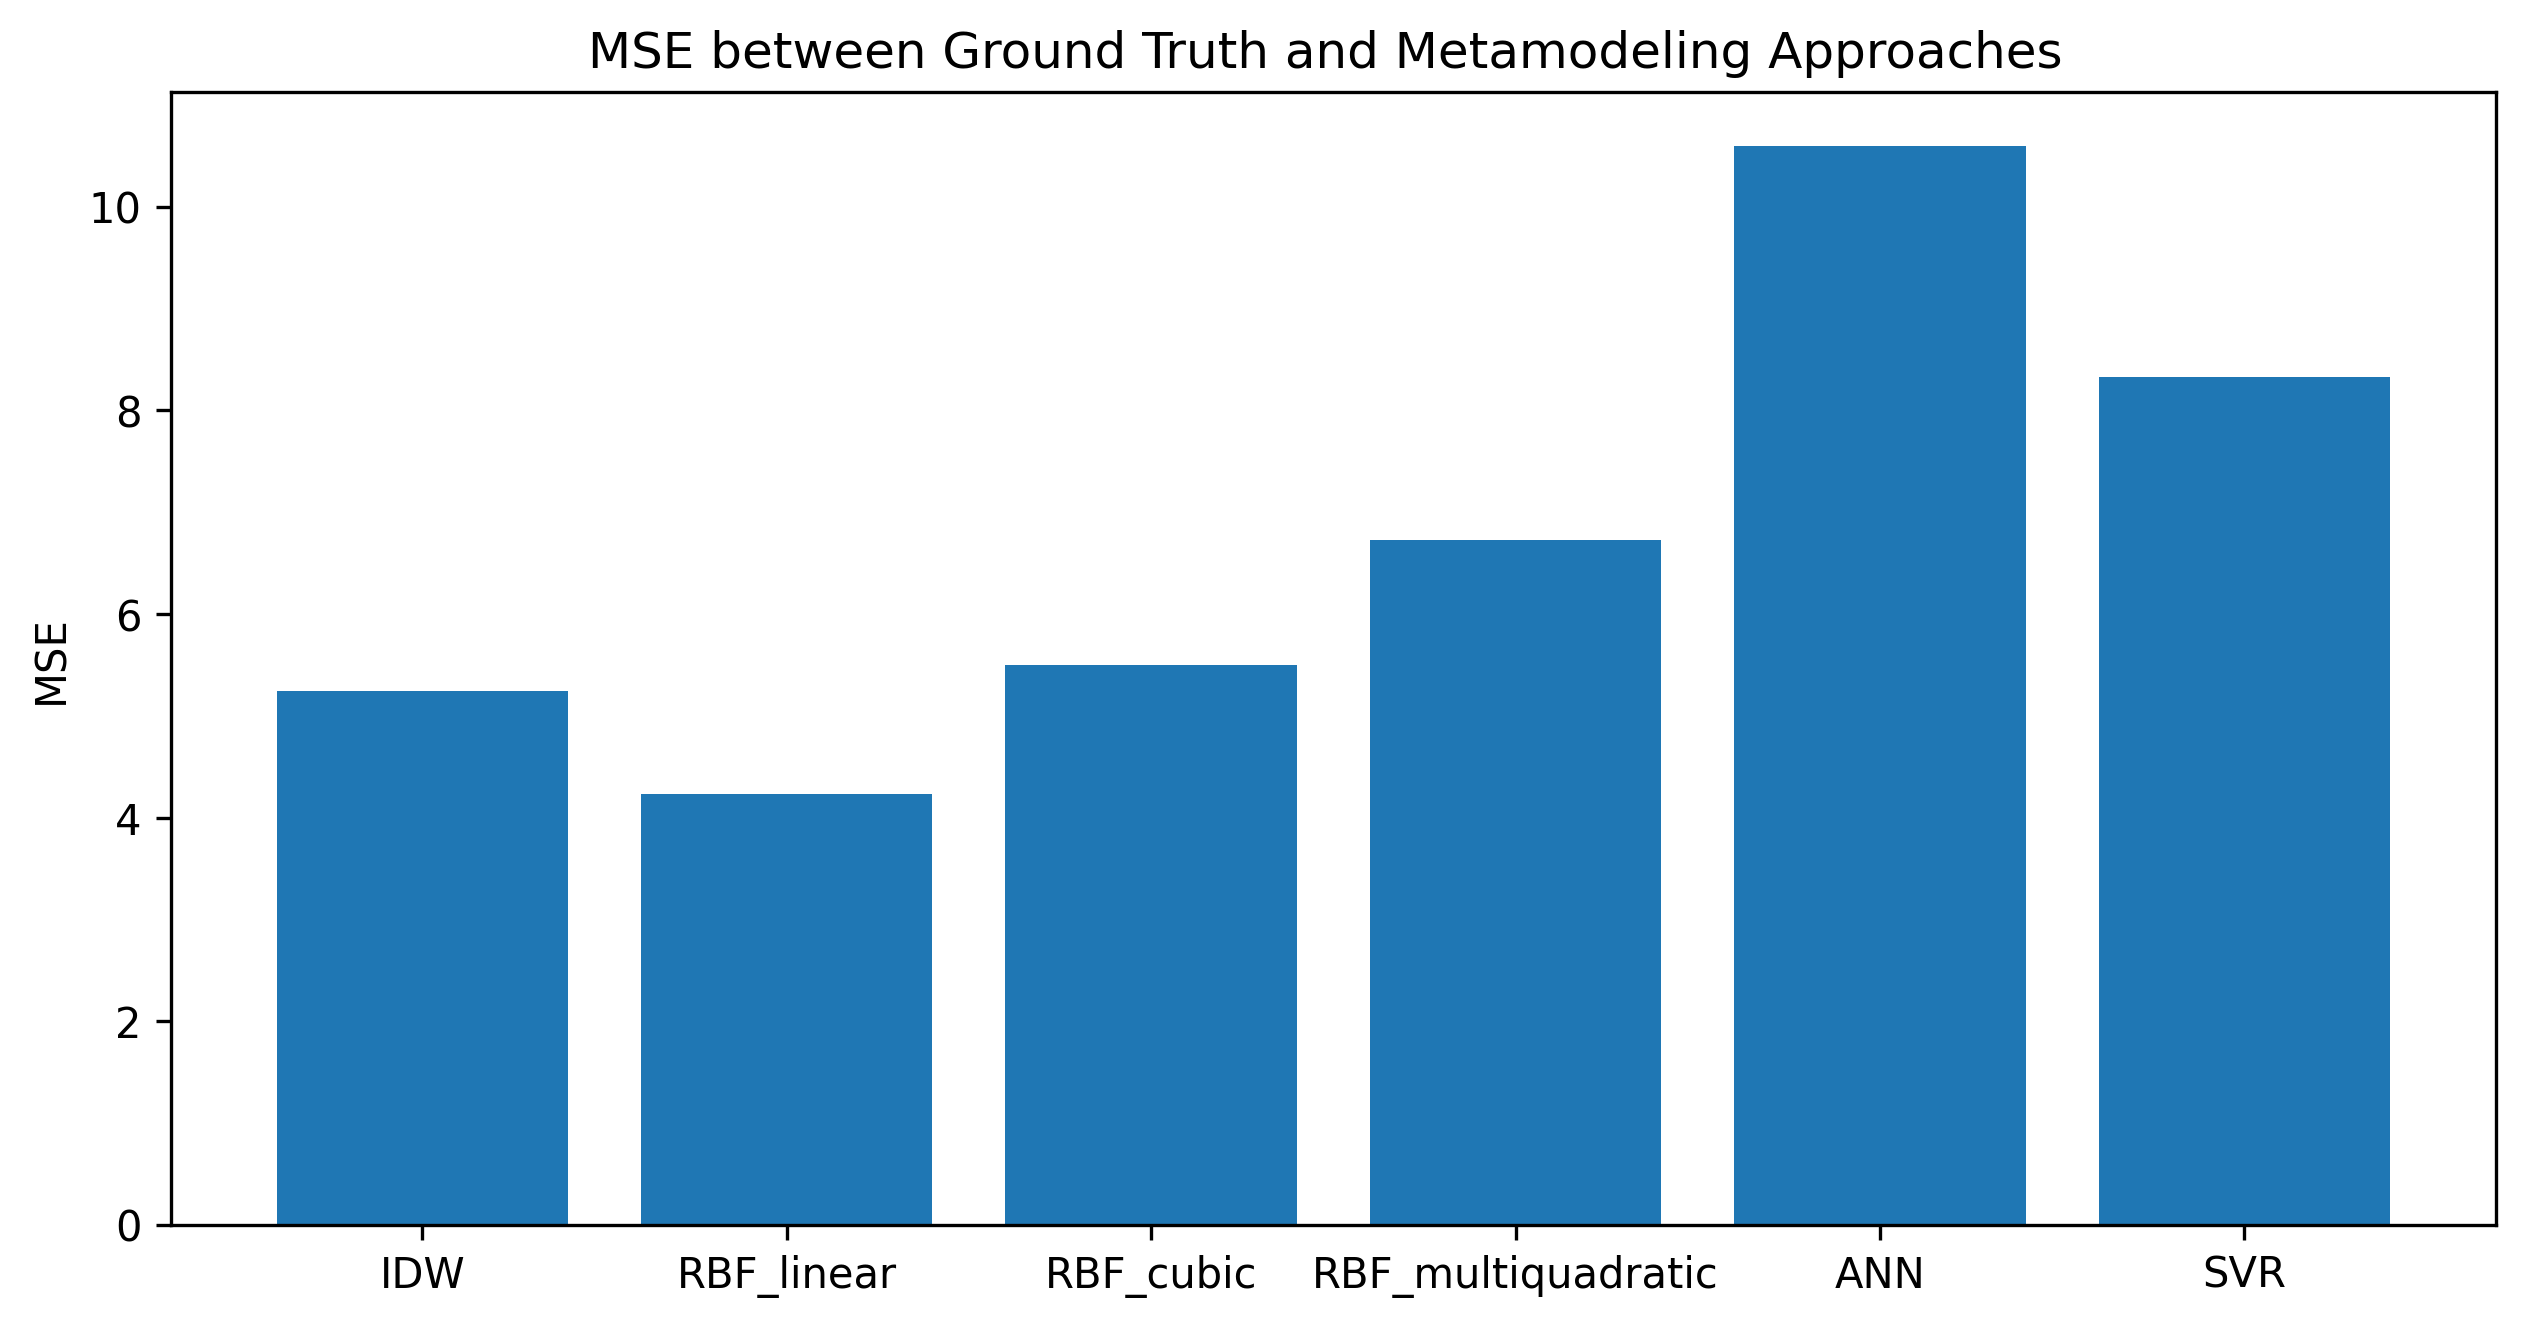

In [14]:
#Compute MSE
#was already using scikit learn, so why not be lazy 

from sklearn.metrics import mean_squared_error as mse

MSE_IDW = mse(r_i_GT,r_i_IDW)
MSE_RBF_lin = mse(r_i_GT,r_i_RBF_lin)
MSE_RBF_cub = mse(r_i_GT,r_i_RBF_cub)
MSE_RBF_mq = mse(r_i_GT,r_i_RBF_mq)
MSE_ANN = mse(r_i_GT,r_i_ANN)
MSE_SVR = mse(r_i_GT,r_i_SVR)

print('MSE_IDW = ', MSE_IDW)
print('MSE_RBF_lin = ', MSE_RBF_lin)
print('MSE_RBF_cub = ', MSE_RBF_cub)
print('MSE_RBF_mq = ', MSE_RBF_mq)
print('MSE_ANN = ', MSE_ANN)
print('MSE_SVR = ', MSE_SVR)


objects = ('IDW', 'RBF_linear','RBF_cubic','RBF_multiquadratic','ANN','SVR')
y_pos = np.arange(len(objects))

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(y_pos, [MSE_IDW,MSE_RBF_lin,MSE_RBF_cub,MSE_RBF_mq,MSE_ANN,MSE_SVR])
plt.xticks(y_pos, objects)
plt.ylabel('MSE')
plt.title('MSE between Ground Truth and Metamodeling Approaches ')
plt.savefig('comparison.png', bbox_inches='tight')